**K-Means and GMM**

**(a) GMM**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler

**1.**

In [3]:
np.random.seed(42)
data = pd.read_csv("C:\\Users\\zachb\\Downloads\\mall_customers.csv")
scaler = MinMaxScaler()
scaler.fit(data)

MinMaxScaler()

In [4]:
data

,Annual_Income,Spending_Score
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40
...,...,...
195,120,79
196,126,28
197,126,74
198,137,18


In [5]:
data = scaler.transform(data)

In [6]:
data

array([[0.        , 0.3877551 ],
       [0.        , 0.81632653],
       [0.00819672, 0.05102041],
       [0.00819672, 0.7755102 ],
       [0.01639344, 0.39795918],
       [0.01639344, 0.76530612],
       [0.02459016, 0.05102041],
       [0.02459016, 0.94897959],
       [0.03278689, 0.02040816],
       [0.03278689, 0.7244898 ],
       [0.03278689, 0.13265306],
       [0.03278689, 1.        ],
       [0.04098361, 0.14285714],
       [0.04098361, 0.7755102 ],
       [0.04098361, 0.12244898],
       [0.04098361, 0.79591837],
       [0.04918033, 0.34693878],
       [0.04918033, 0.66326531],
       [0.06557377, 0.28571429],
       [0.06557377, 0.98979592],
       [0.07377049, 0.34693878],
       [0.07377049, 0.73469388],
       [0.08196721, 0.04081633],
       [0.08196721, 0.73469388],
       [0.10655738, 0.13265306],
       [0.10655738, 0.82653061],
       [0.10655738, 0.31632653],
       [0.10655738, 0.6122449 ],
       [0.1147541 , 0.30612245],
       [0.1147541 , 0.87755102],
       [0.

In [7]:
from scipy.stats import multivariate_normal

def init(X, K):
    n_samples, n_features = X.shape
    omega = np.ones(K) / K
    mu = X[np.random.choice(n_samples, K, replace=False)]
    sigma = [1e-2 * np.eye(n_features) for _ in range(K)]
    return omega, mu, sigma

def normal(X, mu, sigma):
    mvn = multivariate_normal(mean=mu, cov=sigma)
    return mvn.pdf(X)

def expectation(X, omega, mu, sigma, K):
    n_samples, _ = X.shape
    gamma = np.zeros((n_samples, K))
    for k in range(K):
        gamma[:, k] = omega[k] * normal(X, mu[k], sigma[k])
    gamma /= gamma.sum(axis=1, keepdims=True)
    return gamma

def maximization(X, gamma):
    n_samples, n_features = X.shape
    K = gamma.shape[1]
    omega = gamma.sum(axis=0) / n_samples
    mu = np.dot(gamma.T, X) / gamma.sum(axis=0, keepdims=True).T
    sigma = [np.dot((X - mu[k]).T, (gamma[:, k][:, np.newaxis] * (X - mu[k]))) / gamma[:, k].sum() + 1e-6 * np.eye(n_features) for k in range(K)]

    return omega, mu, sigma

def log_likelihood(X, omega, mu, sigma, K):
    n_samples, _ = X.shape
    ll = np.zeros(n_samples)
    for k in range(K):
        ll += omega[k] * normal(X, mu[k], sigma[k])
    ll = np.log(ll).sum()
    return ll

def train_gmm(X, K, max_iter=100, tol=1e-4):
    omega, mu, sigma = init(X, K)
    ll_history = []

    for i in range(max_iter):
        gamma = expectation(X, omega, mu, sigma, K)
        omega, mu, sigma = maximization(X, gamma)
        ll = log_likelihood(X, omega, mu, sigma, K)
        ll_history.append(ll)

        if i > 0 and np.abs(ll - ll_history[i - 1]) < tol:
            break

    return omega, mu, sigma, ll_history

Not sure why this isn't reproducible

[]

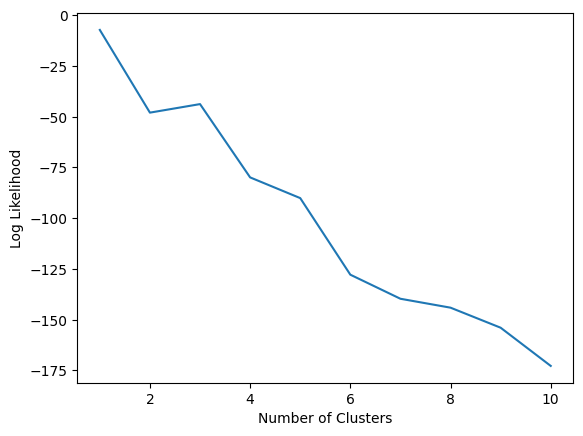

In [8]:
Ks = [1,2,3,4,5,6,7,8,9,10]
losses = []
for k in Ks:
    negloglik = -train_gmm(data, k)[3][-1]
    losses.append(negloglik)

plt.plot(Ks, losses)
plt.xlabel("Number of Clusters")
plt.ylabel("Log Likelihood")
plt.plot()

We see that $K=10$ is best.

**2.**

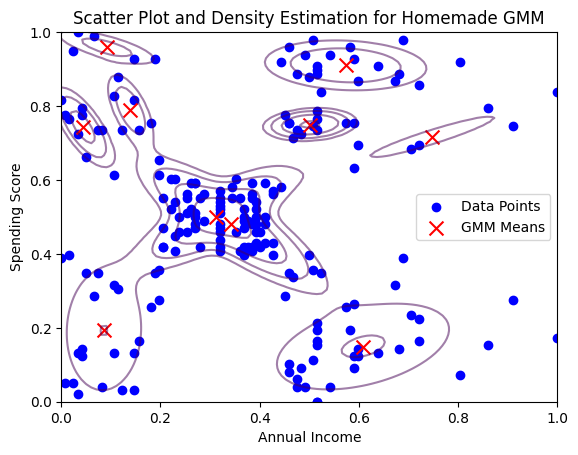

In [9]:
K = 10
omega, mu, sigma, _ = train_gmm(data, K)
plt.scatter(data[:, 0], data[:, 1], marker='o', color='blue', label='Data Points')

x, y = np.meshgrid(np.linspace(data[:, 0].min(), data[:, 0].max(), 100), np.linspace(data[:, 1].min(), data[:, 1].max(), 100))
xy = np.column_stack([x.ravel(), y.ravel()])

density = np.zeros_like(x)
for k in range(K):
    mvn = multivariate_normal(mean=mu[k], cov=sigma[k])
    density += omega[k] * mvn.pdf(xy).reshape(density.shape)

plt.contour(x, y, density, levels=np.logspace(0, 3, 10), cmap='viridis', alpha=0.5)

plt.scatter(mu[:, 0], mu[:, 1], marker='x', color='red', s=100, label='GMM Means')

plt.title('Scatter Plot and Density Estimation for Homemade GMM')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.legend()
plt.show()

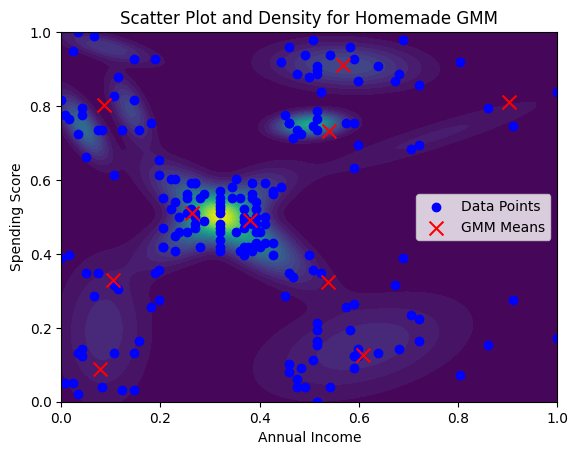

In [12]:
from sklearn import mixture
est = sk.mixture.GaussianMixture(n_components=10, covariance_type='full', init_params='kmeans')
est.fit(data)
x, y = np.meshgrid(np.linspace(data[:, 0].min(), data[:, 0].max(), 100), np.linspace(data[:, 1].min(), data[:, 1].max(), 100))
xy = np.column_stack([x.ravel(), y.ravel()])

z = density

plt.contourf(x, y, z, levels=30, cmap='viridis')
plt.scatter(data[:, 0], data[:, 1], marker='o', color='blue', label='Data Points')
plt.scatter(est.means_[:, 0], est.means_[:, 1], marker='x', color='red', s=100, label='GMM Means')

plt.title('Scatter Plot and Density for Homemade GMM')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.legend()
plt.show()

**3.**

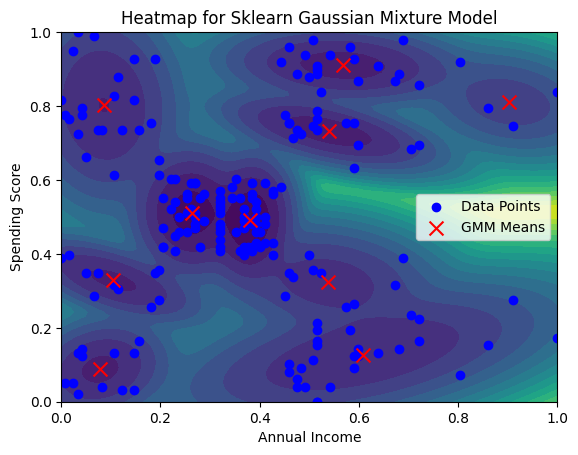

In [13]:
x, y = np.meshgrid(np.linspace(data[:, 0].min(), data[:, 0].max(), 100), np.linspace(data[:, 1].min(), data[:, 1].max(), 100))
xy = np.column_stack([x.ravel(), y.ravel()])

z = -est.score_samples(xy)
z = z.reshape(x.shape)

plt.contourf(x, y, z, levels=20, cmap='viridis')
plt.scatter(data[:, 0], data[:, 1], marker='o', color='blue', label='Data Points')
plt.scatter(est.means_[:, 0], est.means_[:, 1], marker='x', color='red', s=100, label='GMM Means')

plt.title('Heatmap for Sklearn Gaussian Mixture Model')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.legend()
plt.show()

This shows very similar results to what we had before.

**(b) K-Means**

**1.**

In [14]:
from scipy.spatial.distance import cdist

def kmeans(X, K, max_iter=100, tol=1e-4):
    centers = X[np.random.choice(X.shape[0], K, replace=False)]

    for _ in range(max_iter):
        distances = cdist(X, centers, metric='euclidean')
        labels = np.argmin(distances, axis=1)

        new_centers = np.array([X[labels == k].mean(axis=0) for k in range(K)])

        if np.linalg.norm(new_centers - centers) < tol:
            break

        centers = new_centers

    return centers, labels

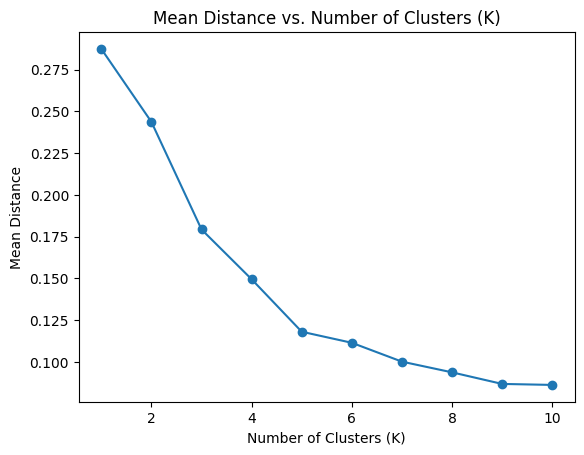

In [17]:
K_values = range(1, 11)
mean_distances = []

for K in K_values:
    centers, labels = kmeans(data, K)
    mean_dist = np.mean(np.linalg.norm(data - centers[labels], axis=1))
    mean_distances.append(mean_dist)

plt.plot(K_values, mean_distances, marker='o')
plt.title('Mean Distance vs. Number of Clusters (K)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Mean Distance')
plt.show()

It looks like $9$ or $10$ is the best option. $9$ gives slightly lower mean distance than $10$ so we're gonna go with it.

**2.**

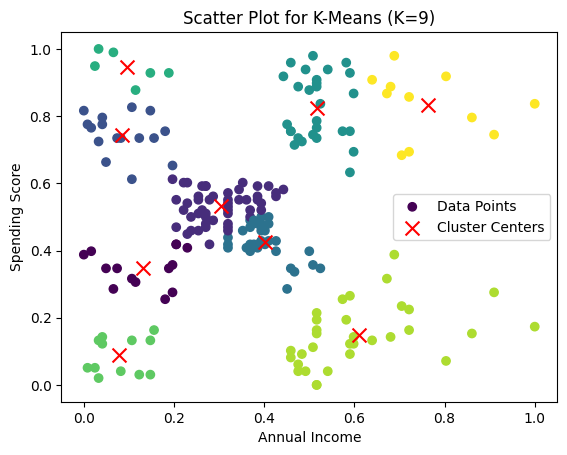

In [35]:
centers, labels = kmeans(data, 9)

plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', marker='o', label='Data Points')
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=100, label='Cluster Centers')

plt.title(f'Scatter Plot for K-Means (K={9})')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.legend()
plt.show()

*Intuitively, what kind of customers does each cluster represent?*

The top right clusters comprise people who make a lot and spend a lot (well-off and prodigal). The bottom right cluster are people who make a lot, but don't spend much (well-off and frugal). The cluster in the top left are people who spend a lot but don't make much (poor and prodigal). The two clusters in the middle are people who spend in-line ('evenly') with what they make. The cluster in the bottom left are people who don't make much and don't spend much (poor and frugal). 

**(c) Connection Between GMM and K-Means**

In [31]:
# I'm just gonna copy over my code from before and modify it

from scipy.stats import multivariate_normal

def init(X, K):
    n_samples, n_features = X.shape
    omega = np.ones(K) / K
    mu = X[np.random.choice(n_samples, K, replace=False)]
    sigma = [1e-3 * np.eye(n_features) for _ in range(K)]
    return omega, mu, sigma

def normal(X, mu, sigma):
    mvn = multivariate_normal(mean=mu, cov=sigma)
    return mvn.pdf(X)

def expectation(X, omega, mu, sigma, K):
    n_samples, _ = X.shape
    gamma = np.zeros((n_samples, K))
    for k in range(K):
        gamma[:, k] = omega[k] * normal(X, mu[k], sigma[k])
    gamma /= gamma.sum(axis=1, keepdims=True)
    return gamma

def maximization(X, gamma):
    n_samples, n_features = X.shape
    K = gamma.shape[1]
    omega = gamma.sum(axis=0) / n_samples
    mu = np.dot(gamma.T, X) / gamma.sum(axis=0, keepdims=True).T
    sigma = [1e-3 * np.eye(n_features) for _ in range(K)]

    return omega, mu, sigma

def log_likelihood(X, omega, mu, sigma, K):
    n_samples, _ = X.shape
    ll = np.zeros(n_samples)
    for k in range(K):
        ll += omega[k] * normal(X, mu[k], sigma[k])
    ll = np.log(ll).sum()
    return ll

def train_gmm(X, K, max_iter=100, tol=1e-4):
    omega, mu, sigma = init(X, K)
    ll_history = []

    for i in range(max_iter):
        gamma = expectation(X, omega, mu, sigma, K)
        omega, mu, sigma = maximization(X, gamma)
        ll = log_likelihood(X, omega, mu, sigma, K)
        ll_history.append(ll)

        if i > 0 and np.abs(ll - ll_history[i - 1]) < tol:
            break

    return omega, mu, sigma, ll_history

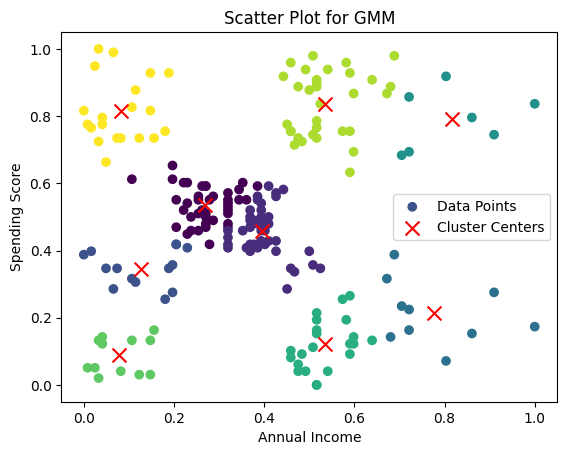

In [34]:
omega, centers, sigma, l1_history = train_gmm(data, 9)

def gmm_predict(X, pi, mu, sigma):
    probabilities = np.array([pi[k] * multivariate_normal.pdf(X, mean=mu[k], cov=sigma[k]) for k in range(len(pi))]).T
    labels = np.argmax(probabilities, axis=1)
    return labels

# I want cluster labels
gmm_labels = gmm_predict(data, omega, centers, sigma)

plt.scatter(data[:, 0], data[:, 1], c=gmm_labels, cmap='viridis', marker='o', label='Data Points')
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=100, label='Cluster Centers')

plt.title(f'Scatter Plot for GMM')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.legend()
plt.show()

By inspection, this performs quite similarly to the K-means done before. Why? Equation 5 is given by $$\frac{\omega_{k,t}g_{k,t}(x_i)}{\sum_{m=1}^K\omega_{m,t}g_{m,t}(x_i)}$$ with $g_{m,t}=\mathcal{N}(\mu_m,\Sigma_m)$. For almost-0 covariance matrix, $g_{n,t}\approx \mu_n$, the mean. So the update is then very close to the K-means update. This is why we see a similarity between K-means and GMM in this case.